# Overview

## Table of Contents

1. Setup
    1. Packages
    2. Utility functions
    3. Dataset and Data module
    4. Model
    5. Inference on select image
    6. Wrapper functions
2. Experiments
    1. canadaojp
    2. canadaOBS
3. Getting predictions
4. Your code here

## Usage

- Run all the cells of the `Setup` section. 
- The cells in the `Experiments` section are to demonstrate code usage and expected behavior. Some of these can be re-run to verify experimental results.
- The cells in the `Getting predictions` section are to demonstrate code usage and expected behavior. These should not be re-run.
- The `Your code here` section is for developing your model(s) in-notebook.

# Setup

## Packages

In [1]:
# Standard library imports
from datetime import datetime
from io import BytesIO
import math
import os
from pathlib import Path
import random
import requests
from typing import List, Optional, Tuple, Union

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import timm
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchmetrics.functional import accuracy
from torchvision.io import read_image
import torchvision.models as models
import torchvision.transforms as transforms

plt.ion()

## Utility functions
I use the words "annotation" and "label" interchangeably. For example, when images are labeled, those labels are saved to an annotations file.

In [2]:
# Used where either a string or a Path object is acceptable
FlexPath = Union[str, Path]

def get_site_names() -> List[str]:
    """
    ----------
    Returns
    ----------
    A list of Phenocam site names, according to the site table.
    """
    site_names = []
    try:
        resp = requests.get('https://phenocam.sr.unh.edu/webcam/network/table/', timeout=10)
        if resp.ok:
            arr0 = resp.text.split('<tbody>')
            arr1 = arr0[1].split('</tbody>')
            arr2 = arr1[0].split('<a href=')
            for i in range(1, len(arr2)):
                name = arr2[i].split('</a>')[0].split('>')[1]
                site_names.append(name)
            return site_names
        else:
            print('Could not retrieve site names')

    except:
        print('Request timed out')
    return None


def get_site_dates(site_name: str) -> Tuple[str, str]:
    """
    ----------
    Parameters
    ----------
    site_name: The name of the Phenocam site to download from (e.g., canadaojp).
    
    ---------
    Returns
    ---------
    A 2-tuple where the first element is the start date and the second element is the
    end date corresponding to the given site. If the dates cannot be found, a 2-tuple
    where both elements are None is returned.
    
    ---------
    Example
    ---------
    >>> get_site_dates('canadaojp')
    ('2015-12-31', '2020-12-31')
    """
    start_date, end_date = None, None
    try:
        resp = requests.get(f'https://phenocam.sr.unh.edu/webcam/sites/{site_name}/', timeout=10)
        if resp.ok:
            start_date = resp.text.split('<strong>Start Date:</strong> ')[1][:10]
            end_date = resp.text.split('<strong>Last Date:</strong> ')[1][:10]
        else:
            print('Could not retrieve start and end date')
    except:
        print('Request timed out')
    return (start_date, end_date)


def download(site_name: str, 
             dates: Tuple[str, str],
             save_to: FlexPath,
             n_photos: int) -> None:
    """
    ----------
    Parameters
    ----------
    site_name: The name of the site to download from. A list of acceptable site names
        can be found by running get_site_names().
    dates: A 2-tuple indicating the range of dates you want your downloaded photos
        to come from. A 2-tuple of the max possible range for site my_site can be found
        by running get_site_dates(my_site).
    save_to: The directory to save the downloaded images to. If the directory
        already exists, it is NOT cleared. The new photos will simply be added to the 
        directory, except for duplicates, which are skipped.
    n_photos: The number of photos to be downloaded.
                   
    ----------
    Returns
    ----------
    None
    
    ----------
    Example
    ----------
    >>> download('canadojp', ('2017-03-01', '2017-04-01'), 'my_photos', 1)
    """
    # Check that the directory we are saving to exists
    if type(save_to) is not Path:
        save_dir = Path(save_to)
    else:
        save_dir = save_to
    if not save_dir.is_dir():
        os.mkdir(save_dir)
    
    # Configure logger
    log_filename = f'{datetime.now().isoformat().split(".")[0].replace(":", "-")}.log'
    log_filepath = save_dir.joinpath(log_filename)
    
    with open(log_filepath, 'a') as log_file:
        # Randomly order all possible timestamps
        date_range = list(pd.date_range(start=dates[0], end=dates[1], freq='30min'))
        random.shuffle(date_range)

        # Download images
        home_url = f'https://phenocam.sr.unh.edu/webcam/browse/{site_name}'
        img_template = f'https://phenocam.sr.unh.edu/data/archive/{site_name}'
        n_downloaded = 0
        
        # Keep downloading until the number downloaded is the number requested
        # or until we are out of dates to sample images from
        while n_downloaded < n_photos and len(date_range) > 0:
            my_datetime = date_range.pop()
            Y = str(my_datetime.year)
            m = str(my_datetime.month).zfill(2)
            D = str(my_datetime.day).zfill(2)
            month_url = f'{home_url}/{Y}/{m}/{D}'
            try:
                resp1 = requests.get(month_url, timeout=5)
            except:
                log_file.write(f'ERROR:Request timed out\n')
                continue
            if resp1.ok: # Access the archive for the chosen timestamp's month
                arr = resp1.text.split('<span class="imglabel">')[1:]
                success = False
                for a in arr:
                    orig_timestamp = a.split('&nbsp')[0].strip()
                    strip_timestamp = orig_timestamp.replace(':', '')
                    try:
                        pd_timestamp = pd.to_datetime(f'{Y}-{m}-{D} {orig_timestamp}')
                    except:
                        log_file.write(f'WARN:Could not parse {orig_timestamp}\n')
                        break
                    # Find the image within 5 minutes of the chosen timestamp
                    if abs(my_datetime - pd_timestamp) <= pd.Timedelta('5min'):
                        img_fname = f'{site_name}_{Y}_{m}_{D}_{strip_timestamp}.jpg'
                        img_url = f'{img_template}/{Y}/{m}/{img_fname}'
                        output_fpath = save_dir.joinpath(img_fname)
                        if output_fpath.is_file():
                            log_file.write(f'WARN:{img_fname} was already downloaded, skipping\n')
                            break
                        try:
                            resp2 = requests.get(img_url, timeout=5)
                        except Exception as e:
                            log_file.write(f'ERROR:{e}\n')
                        if resp2.ok:
                            try:
                                img = Image.open(BytesIO(resp2.content))
                                img.save(output_fpath)
                                success = True
                                n_downloaded += 1
                                log_file.write(f'INFO:Retrieved {resp2.url}\n')
                            except:
                                log_file.write(f'WARN:Could not read or save image from {resp2.url}\n')
                            break
                        else:
                            log_file.write(f'WARN:Could not reach {resp2.url}\n')
                if not success:
                    log_file.write(f'WARN:Could not find an image within 5 minutes of {str(my_datetime)}\n')
            else:
                log_file.write(f'WARN:Could not reach {month_url}\n')


def download_from_log(source_log: FlexPath, 
                      save_to: FlexPath) -> None:
    """
    ----------
    Parameters
    ----------
    source_log: The log file to get image URLs from.
    save_to: The directory to save images to.
    
    ----------
    Returns
    ----------
    None.
    """
    # Check that the directory we're saving to exists
    if type(save_to) is not Path:
        save_dir = Path(save_to)
    else:
        save_dir = save_to
    if not save_dir.is_dir():
        os.mkdir(save_dir)
    
    # Configure logger
    log_filename = f'{datetime.now().isoformat().split(".")[0].replace(":", "-")}.log'
    log_filepath = save_dir.joinpath(log_filename)
    
    # Read URLs from the source log
    img_urls = []
    with open(source_log, 'r') as f:
        for line in f:
            if line.startswith('INFO:Retrieved '):
                url = line.split(' ')[1].strip()
                img_urls.append(url)
    
    # Download images
    with open(log_filepath, 'a') as f:
        f.write(f'INFO:Read {len(img_urls)} image URLs from {str(source_log)}\n')
        for url in img_urls:
            try:
                resp = requests.get(url, timeout=5)
            except:
                f.write('ERROR:Request timed out\n')
                break
            if resp.ok:
                try:
                    img_fname = url.split('/')[-1]
                    output_fpath = save_dir.joinpath(img_fname)
                    img = Image.open(BytesIO(resp.content))
                    img.save(output_fpath)
                    f.write(f'INFO:Retrieved {resp.url}\n')
                except:
                    f.write(f'WARN:Could not read or save image from {resp.url}\n')
            else:
                f.write(f'ERROR:Bad response for {resp.url}\n')
            
                
                
def label_images_in_notebook(site_name: str, 
                             categories: List[str],
                             img_dir: FlexPath, 
                             save_to: FlexPath) -> None:
    """
    ----------
    Parameters
    ----------
    site_name: The name of the site.
    categories: A list of unique labels. When labeling images, you can type
        either the full label name or its index. E.g., if your labels
        are ['cat', 'dog'], when given a picture of a cat, you can
        type either 'cat' or '0'.
    img_dir: A directory containing images to be labeled. Assumes all images
        are jpg.
    save_to: The path of the file to write the labels out to.
    
    ----------
    Returns
    ----------
    None
    
    ----------
    Example
    ----------
    >>> label_images('canadaojp', ['too dark', 'snow', 'no snow'], \
        'my_photos', 'my_photos/labels.csv')
    """
    # Check that the image directory exists
    if type(img_dir) is not Path:
        img_dir = Path(img_dir)
    assert img_dir.is_dir()
    
    # Check for uniqueness of image categories
    assert len(list(set(categories))) == len(categories), \
        'Non-unique categories detected'
    
    # Interactively label images
    timestamps, labels = [], []
    i = 0
    for img_fpath in img_dir.glob('*.jpg'):
        img = plt.imread(img_fpath)
        plt.imshow(img)
        plt.pause(0.0001) # https://stackoverflow.com/questions/12670101/matplotlib-ion-function-fails-to-be-interactive
        assigned_label = None
        print(f'Picture {i}')
        while assigned_label not in categories:
            assigned_label = input('Label: ')
            try:
                if int(assigned_label) >= 0 and int(assigned_label) < len(categories):
                    assigned_label = categories[int(assigned_label)]
                    break
            except:
                pass
        ts_arr = img_fpath.stem.split('_')
        ts = '-'.join(ts_arr[1:4])
        hms = ts_arr[-1]
        ts += f' {hms[:2]}:{hms[2:4]}:{hms[4:]}'
        timestamps.append(ts)
        labels.append(assigned_label)
        i += 1
    
    # Save annotations to file
    df = pd.DataFrame(zip(timestamps, labels), columns=['timestamp', 'label'])
    with open(save_to, 'w+') as f:
        f.write(f'# Site: {img_dir.stem if site_name is None else site_name}\n')
        f.write('# Categories:\n')
        for i, cat in enumerate(categories):
            f.write(f'# {i}. {cat}\n')
    df.to_csv(save_to, mode='a', line_terminator='\n', index=False)
    
    
def label_images_via_subdir(site_name: str,
                            categories: List[str],
                            img_dir: FlexPath, 
                            save_to: FlexPath) -> None:
    """
    ----------
    Parameters
    ----------
    site_name: The name of the site.
    categories: A list of unique labels. These should match the names of 
        the image subdirectories.
    img_dir: The directory containing the image subdirectories.
    save_to: Where to save the annotations file.
    
    ---------
    Returns
    ---------
    None.
    """
    # Check that the image directory exists
    if type(img_dir) is not Path:
        img_dir = Path(img_dir)
    assert img_dir.is_dir()
    
    # Check that the category subdirectories exist
    dircats = []
    for cat in categories:
        dircat = img_dir.joinpath(Path(cat))
        dircats.append(dircat)
        if not dircat.exists() or not dircat.is_dir():
            os.mkdir(dircat)
            
    # Await user acknowledgement
    input('Move images into the appropriate sub-directory then press any key to continue.')
    
    # Create annotations file
    timestamps = []
    for dircat in dircats:
        timestamps_subarr = []
        for img_fpath in dircat.glob('*.jpg'):
            ts_arr = img_fpath.stem.split('_')
            ts = '-'.join(ts_arr[1:4])
            hms = ts_arr[-1]
            ts += f' {hms[:2]}:{hms[2:4]}:{hms[4:]}'
            timestamps_subarr.append(ts)
        timestamps.append(timestamps_subarr)
    df = pd.DataFrame(zip(timestamps, categories), columns=['timestamp', 'label']).explode('timestamp')
    with open(save_to, 'w+') as f:
        f.write(f'# Site: {img_dir.stem if site_name is None else site_name}\n')
        f.write('# Categories:\n')
        for i, cat in enumerate(categories):
            f.write(f'# {i}. {cat}\n')
    df.to_csv(save_to, mode='a', line_terminator='\n', index=False)
    
    # Flatten directory (i.e., pull all images out of the subdirectories
    # back into their original directory)
    for item in img_dir.glob('*'):
        if item.is_dir():
            for subitem in sorted(item.glob('*')):
                new_path = Path(subitem.resolve().parent.parent).joinpath(subitem.name)
                subitem.rename(new_path)

    
def read_annotations(ann_file: FlexPath) -> pd.DataFrame:
    """
    -----------
    Parameters
    -----------
    ann_file: The annotation file's path, as a string or a Path object.
        The annotation file should be in the same format as that which is 
        returned by label_images_in_notebook or label_images_via_subdir.
    
    -----------
    Returns
    -----------
    A Pandas DataFrame containing the annotations.
    """    
    # Extract meta information
    site_name = pd.read_csv(ann_file, nrows=1, header=None)[0].tolist()[0].split('# Site: ')[1]
    labels_dict = {}
    with open(ann_file, 'r') as f:
        start_reading = False
        for line in f:
            if start_reading:
                if line[0] != '#':
                    break
                else:
                    int_label, str_label = line[1:].split('. ')
                    int_label = int(int_label)
                    str_label = str_label.strip()
                    labels_dict[str_label] = int_label
            if line == '# Categories:\n':
                start_reading = True
    
    # Sort timestamps
    df = pd.read_csv(ann_file, comment='#')
    df.set_index('timestamp', inplace=True)
    df.sort_index(inplace=True)
    
    # Encode the labels as integers
    df['label'] = df['label'].astype('category')
    df['int_label'] = [labels_dict[x] for x in df['label']]
    
    # Create image file names from timestamps
    img_name_col = []
    for ts in df.index:
        year = ts[:4]
        month = ts[5:7]
        day = ts[8:10]
        hms = ts.split(' ')[1].replace(':', '')
        img_name_col.append(f'{site_name}_{year}_{month}_{day}_{hms}.jpg')
    df['img_name'] = img_name_col
    
    return df

## Dataset and Data module

In [3]:
class PhenocamImageDataset(Dataset):
    def __init__(self, img_dir, ann_file, transform=None, target_transform=None):
        """
        ----------
        Parameters
        ----------
        img_dir: The directory where all the images are contained.
        ann_file: The file path of the annotations file for the images in img_dir.
            See read_annotations().
        transform: The transform to apply to images.
        target_transform: The transform to apply to image labels.
        """
        df = read_annotations(ann_file)
        self.img_labels = df[['img_name', 'int_label']].reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        img = read_image(img_path) / 255
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            label = self.target_transform(label)
        return img, label
    

class PhenoCamDataModule(pl.LightningDataModule):
    def __init__(self, 
                 site_name: str, 
                 train_dir: Union[str, Path], 
                 train_anns: Union[str, Path],
                 test_dir: Union[str, Path],
                 test_anns: Union[str, Path],
                 batch_size: Optional[int] = 16) -> None:
        """
        ----------
        Parameters
        ----------
        site_name: The name of the Phenocam site this data module is for.
        train_dir: The directory containing the train images.
        train_anns: The path to the train annotations.
        test_dir: The directory containing the test images.
        test_anns: The path to the test annotations.
        batch_size: The batch size for the data module. (Default is 16).
        
        ----------
        Returns
        ----------
        None.
        """
        super().__init__()
        
        self.site_name = site_name
        self.train_dir = train_dir
        self.train_annotations = train_anns
        self.test_dir = test_dir
        self.test_annotations = test_anns
        self.batch_size = batch_size
        
        # Augmentation policy for training set        
        self.aug_transform = transforms.Compose([
            transforms.Resize(224, interpolation=3),
            transforms.RandomApply([transforms.GaussianBlur(3)]),
            transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD)
        ])
        # I once tried applying other augmentation steps in between
        # resizing and blurring but found that these greatly reduced
        # accuracy on the canadaOBS site - often lead to NaN loss.
        
        # Preprocessing steps applied to test data
        self.std_transform = transforms.Compose([
            transforms.Resize(224, interpolation=3),
            transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD)
        ])        
        
    def prepare_data(self, 
                     train_download_args: Optional[dict] = None, 
                     train_label_args: Optional[dict] = None,
                     test_download_args: Optional[dict] = None,
                     test_label_args: Optional[dict] = None) -> None: 
        """
        ----------
        Parameters
        ----------
        train_download_args: Arguments for downloading train images. See download().
        train_label_args: Arguments for labeling train images. Needs to have a key
            called 'method' which has two valid values: 'in notebook' and 'via subdir'.
            If method is 'in_notebook', then the other keys should match the parameters
            required by label_images_in_notebook(). If the method is 'via_subdir', then
            the other keys should match the parameters required by
            label_images_via_subdir().
        test_download_args: Arguments for downloading test images. See download().
        test_label_args: Argument for labeling test images. See the note for 
            train_label_args.
            
        ----------
        Returns
        ----------
        None.
        
        ----------
        Example
        ----------
        >>> train_download_args = dict(
            site_name='vindeln2',
            dates=get_site_dates('vindeln2'),
            save_to='train_dir',
            n_photos=120)
        >>> train_label_args = dict(
            method='in notebook',
            site_name='vindeln2'
            categories=['no snow', 'too dark', 'snow']
            img_dir='train_dir'
            save_to='train_dir/annotations.csv')
        >>> test_download_args = dict(
            site_name='vindeln2', # the train and test sites must be the same
            dates=get_site_dates('vindeln2'),
            save_to='test_dir',
            n_photos=30)
        >>> test_label_args = dict(
            method='via subdir',
            site_name='vindeln2',
            categories=['no snow', 'too dark', 'snow'] # the order of the categories must be preserved
            img_dir='test_dir',
            save_to='test_dir/annotations.csv')
        >>> prepare_data(train_download_args, 
                         train_label_args,
                         test_download_args,
                         test_label_args)
        """
        # Download and/or label train data
        if train_download_args:
            assert train_download_args['site_name'] == self.site_name
            assert train_download_args['save_to'] == self.train_dir
            print('Downloading train data')
            download(**train_download_args)
        if train_label_args:
            assert train_label_args['img_dir'] == self.train_dir
            assert train_label_args['save_to'] == self.train_annotations
            print('Labeling train data')
            if train_label_args['method'] == 'in notebook':
                del train_label_args['method']
                label_images_in_notebook(**train_label_args)
            elif train_label_args['method'] == 'via subdir':
                del train_label_args['method']
                label_images_via_subdir(**train_label_args)
            
        # Download and/or label test data
        if test_download_args:
            assert test_download_args['site_name'] == self.site_name
            assert test_download_args['save_to'] == self.test_dir
            print('Downloading test data')
            download(**test_download_args)
        if test_label_args:
            assert test_label_args['img_dir'] == self.test_dir
            assert test_label_args['save_to'] == self.test_annotations
            print('Labeling test data')
            if test_label_args['method'] == 'in notebook':
                del test_label_args['method']
                label_images_in_notebook(**test_label_args)
            elif test_label_args['method'] == 'via subdir':
                del test_label_args['method']
                label_images_via_subdir(**test_label_args)
        
    def setup(self, stage: Optional[str] = None):
        """
        ----------
        Parameters
        ----------
        stage: If the stage is 'fit', the train data is split 70/30 into train and validation
            sets. The augmented transformation policy is applied to the images. If the stage is
            'test', the test dataset is loaded and the standard transformation is applied to
            the images. (Default is None, in which case, the train, validation, and test
            datasets are all loaded.)
            
        ----------
        Returns
        ----------
        None.
        """
        if stage in ('fit', None):
            img_dataset = PhenocamImageDataset(self.train_dir, self.train_annotations, transform=self.aug_transform)
            train_size = round(len(img_dataset) * 0.7)
            val_size = len(img_dataset) - train_size
            self.img_train, self.img_val = random_split(img_dataset, [train_size, val_size])
            self.dims = self.img_train[0][0].shape
        if stage in ('test', None):
            self.img_test = PhenocamImageDataset(self.test_dir, self.test_annotations, transform=self.std_transform)
            self.dims = getattr(self, 'dims', self.img_test[0][0].shape)
            
    def train_dataloader(self):
        return DataLoader(self.img_train, batch_size=self.batch_size)
    
    def val_dataloader(self):
        return DataLoader(self.img_val, batch_size=self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(self.img_test, batch_size=self.batch_size)
    
    def predict_dataloader(self):
        return DataLoader(self.img_test, batch_size=self.batch_size)
    
    def get_categories(self) -> List[str]:
        """ 
        ----------
        Returns
        ----------
        A list of the image categories, ordered according to their
        integer encoding.
        """
        train_categories = []
        with open(self.train_annotations, 'r') as f:
            start_reading = False
            for line in f:
                if start_reading:
                    if line[0] != '#':
                        break
                    else:
                        _, str_label = line[1:].split('. ')
                        str_label = str_label.strip()
                        train_categories.append(str_label)
                if line == '# Categories:\n':
                    start_reading = True

        test_categories = []
        with open(self.test_annotations, 'r') as f:
            start_reading = False
            for line in f:
                if start_reading:
                    if line[0] != '#':
                        break
                    else:
                        _, str_label = line[1:].split('. ')
                        str_label = str_label.strip()
                        test_categories.append(str_label)
                if line == '# Categories:\n':
                    start_reading = True
                    
        assert train_categories == test_categories
        return train_categories

## Model

In [4]:
class PhenoCamResNet(pl.LightningModule):
    def __init__(self, 
                 n_classes: int, 
                 lr: Optional[float] = 2e-4) -> None:
        """
        ----------
        Parameters
        ----------
        n_classes: The number of classes to identify.
        lr: The learning rate. (Default is 2e-4, which I empirically found to produce
            good results.)
            
        ----------
        Returns
        ----------
        None.
        """
        super().__init__()
        
        self.save_hyperparameters()
        self.lr = lr # Leaving this here in case we want to do auto LR tuning in the future

        # Initialize a pretrained Resnet18
        backbone = models.resnet18(pretrained=True)
        n_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]
        
        # Freeze the feature extraction layers
        self.feature_extractor = nn.Sequential(*layers)
        self.feature_extractor.eval()
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

        # Use results of pre-trained feature extractor to classify
        self.classifier = nn.Linear(n_filters, n_classes)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        with torch.no_grad():
            z = self.classifier(x)
            z = F.log_softmax(z, dim=1) 
        return z
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        z = self.classifier(x)
        z = F.log_softmax(z, dim=1)
        loss = F.cross_entropy(z, y)
        self.log('train_loss', loss)
        return loss
    
    def evaluate(self, batch, stage=None):
        x, y = batch
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        with torch.no_grad():
            z = self.classifier(x)
            z = F.log_softmax(z, dim=1)
        loss = F.cross_entropy(z, y)
        preds = torch.argmax(z, dim=1)
        acc = accuracy(preds, y)
        
        if stage:
            self.log(f'{stage}_loss', loss, prog_bar=True)
            self.log(f'{stage}_acc', acc, prog_bar=True)
    
    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, 'val')
        
    def test_step(self, batch, batch_idx):
        self.evaluate(batch, 'test')

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

## Inference on select image

In [5]:
def classify_online(model: PhenoCamResNet,
                    categories: List[str],
                    img_url: str) -> Tuple[np.ndarray, str]:
    """
    ----------
    Parameters
    ----------
    model: The model to use.
    categories: A list of the image categories.
    img_url: The URL of the image to run classification on.
    
    ----------
    Returns
    ----------
    A 2-tuple where the first element is the image at img_url as a NumPy
    array and the second element is the predicted label for this image.
    
    ----------
    Example
    ----------
    >>> model = PhenoCamResNet()
    >>> categories = ['too dark', 'no snow', 'snow']
    >>> url = 'https://phenocam.sr.unh.edu/data/latest/canadaOBS.jpg'
    >>> classify_online(model, categories, url)
    ([some_np_array], 'snow')
    """
    try:
        resp = requests.get(img_url, timeout=5)
    except:
        print('Request timed out')
    if resp.ok:
        img = Image.open(BytesIO(resp.content))
        np_img = np.array(img)
        x = transforms.ToTensor()(img)
        dm = PhenoCamDataModule('dummy_site_name',
                                'dummy_train_dir',
                                'dummy_train_anns',
                                'dummy_test_dir',
                                'dummy_test_anns')
        x = dm.std_transform(x.unsqueeze(0))
        z = model(x)
        pred = categories[torch.argmax(z, dim=1)]
        return (np_img, pred)
    else:
        print('Error occurred')
    return None

def classify_offline(model: PhenoCamResNet,
                     categories: List[str],
                     img_path: FlexPath) -> Tuple[np.ndarray, str]:
    """
    ----------
    Parameters
    ----------
    model: The model to use.
    categories: A list of the image categories.
    img_path: The path of the image to run classification on.
    
    ----------
    Returns
    ----------
    A 2-tuple where the first element is the image at img_url as a NumPy
    array and the second element is the predicted label for this image.
    
    ----------
    Example
    ----------
    >>> model = PhenoCamResNet()
    >>> categories = ['too dark', 'no snow', 'snow']
    >>> img_path = 'canadaOBS_test/test_img.jpg'
    >>> classify_offline(model, categories, img_path)
    ([some_np_array], 'too dark') 
    """
    dm = PhenoCamDataModule('dummy_site_name',
                            'dummy_train_dir',
                            'dummy_train_anns',
                            'dummy_test_dir',
                            'dummy_test_anns')
    x = dm.std_transform((read_image(img_path) / 255).unsqueeze(0))
    z = model(x)
    pred = categories[torch.argmax(z, dim=1)]
    return pred


## Wrapper functions
You *could* do everything yourself, but here's some snappy functions to do things fast!

In [6]:
def train_model_with_new_data(site_name: str,
                              label_method: str,
                              categories: List[str],
                              n_train: int,
                              n_test: int,
                              deterministic: Optional[bool] = False) -> PhenoCamResNet:
    """
    ----------
    Parameters
    ----------
    site_name: The name of the PhenoCam site you want to train a model for.
    label_method: How do you want to label images? ("in notebook" or "via subdir")
    categories: What categories should this model learn? (e.g., "too dark", "no snow", "snow")
    n_train: The total number of train images to download.
    n_test: The total number of test images to download.
    deterministic: Whether the trainer should have the deterministic flag enabled.

    ----------
    Returns
    ----------
    The best model from training.
    """
    ##############################
    # 1. Download and label data #
    ##############################
    valid_label_methods = ['in notebook', 'via subdir']
    assert label_method in valid_label_methods

    train_dir = f'{site_name}_train'
    test_dir = f'{site_name}_test'
    train_annotations = f'{train_dir}/annotations.csv'
    test_annotations = f'{test_dir}/annotations.csv'

    dm_args = dict(
        site_name=site_name,
        train_dir=train_dir,
        train_anns=train_annotations,
        test_dir=test_dir,
        test_anns=test_annotations
    )
    dm = PhenoCamDataModule(**dm_args)

    # Train data arguments
    train_download_args = dict(
        site_name=site_name,
        dates=get_site_dates(site_name),
        save_to=train_dir,
        n_photos=n_train
    )
    # Train label arguments
    train_label_args = dict(
        site_name=site_name,
        categories=categories,
        img_dir=train_dir,
        save_to=train_annotations,
        method=label_method
    )

    # Test data arguments
    test_download_args = dict(
        site_name=site_name,
        dates=get_site_dates(site_name),
        save_to=test_dir,
        n_photos=n_test
    )
    # Test label arguments
    test_label_args = dict(
        site_name=site_name,
        categories=categories,
        img_dir=test_dir,
        save_to=test_annotations,
        method=label_method
    )

    dm.prepare_data(train_download_args,
                    train_label_args,
                    test_download_args,
                    test_label_args)

    ##################
    # 2. Train model #
    ##################
    dm.setup(stage='fit')
    model = PhenoCamResNet(n_classes=len(categories))
    logger = TensorBoardLogger(
        save_dir=os.getcwd(), name=f'{site_name}_lightning_logs')
    trainer = pl.Trainer(gpus=1, log_every_n_steps=6,
                         gradient_clip_val=0.01, max_epochs=50, logger=logger, deterministic=deterministic)
    trainer.fit(model, dm)

    #####################
    # 3. Evaluate model #
    #####################
    dm.setup(stage='test')
    trainer.test(datamodule=dm, ckpt_path='best')

    ######################
    # 4. Note best model #
    ######################
    best_model_path = trainer.checkpoint_callback.best_model_path
    best_models_csv = Path('best_model_paths.csv')
    if not best_models_csv.exists():
        with open(best_models_csv, 'w') as f:
            f.write('timestamp,site_name,best_model\n')
    with open(best_models_csv, 'a') as f:
        f.write(f'{datetime.now().isoformat()},{site_name},{best_model_path}\n')

    ########################
    # 5. Return best model #
    ########################
    best_model = model.load_from_checkpoint(best_model_path)
    best_model.freeze()
    print(f'Path of best model: {best_model_path}')
    return best_model


def train_model_with_existing_data(site_name: str,
                                   train_dir: FlexPath,
                                   test_dir: FlexPath,
                                   deterministic: Optional[bool] = False) -> PhenoCamResNet:
    """
    ----------
    Parameters
    ----------
    site_name: Site name.
    train_dir: Directory with training images and labels.
    test_dir: Directory with testing images and labels.
    deterministic: Whether the trainer should have the deterministic flag enabled.

    ----------
    Returns
    ----------
    The best model from training.
    """

    ###################
    # 1. Prepare data #
    ###################
    if type(train_dir) is str:
        train_dir = Path(train_dir)
    if type(test_dir) is str:
        test_dir = Path(test_dir)
    dm_args = dict(
        site_name=site_name,
        train_dir=train_dir,
        train_anns=train_dir.joinpath('annotations.csv'),
        test_dir=test_dir,
        test_anns=test_dir.joinpath('annotations.csv')
    )
    dm = PhenoCamDataModule(**dm_args)
    dm.prepare_data()

    ##################
    # 2. Train model #
    ##################
    dm.setup(stage='fit')
    model = PhenoCamResNet(n_classes=len(dm.get_categories()))
    logger = TensorBoardLogger(
        save_dir=os.getcwd(), name=f'{site_name}_lightning_logs')
    trainer = pl.Trainer(gpus=1, log_every_n_steps=6,
                         gradient_clip_val=0.01, max_epochs=50, logger=logger, deterministic=deterministic)
    trainer.fit(model, dm)

    #####################
    # 3. Evaluate model #
    #####################
    dm.setup(stage='test')
    trainer.test(datamodule=dm, ckpt_path='best')

    ######################
    # 4. Note best model #
    ######################
    best_model_path = trainer.checkpoint_callback.best_model_path
    best_models_csv = Path('best_model_paths.csv')
    if not best_models_csv.exists():
        with open(best_models_csv, 'w') as f:
            f.write('timestamp,site_name,best_model\n')
    with open(best_models_csv, 'a') as f:
        f.write(f'{datetime.now().isoformat()},{site_name},{best_model_path}\n')

    ########################
    # 5. Return best model #
    ########################
    best_model = model.load_from_checkpoint(best_model_path)
    best_model.freeze()
    print(f'Path of best model: {best_model_path}')
    return best_model


def load_model_from_file(model_path: FlexPath, n_classes: int) -> PhenoCamResNet:
    """
    ----------
    Parameters
    ----------
    model_path: The filepath where the model is stored.
    n_classes: The number of classes this model predicts.

    ----------
    Returns
    ----------
    The loaded model.
    """
    model = PhenoCamResNet(n_classes).load_from_checkpoint(model_path)
    model.freeze()
    return model


def run_model_offline(model: PhenoCamResNet, 
                      site_name: str, 
                      categories: List[str], 
                      img_dir: FlexPath) -> None:
    """
    ----------
    Description
    ----------
    Gets predicted labels for all the images in img_dir and writes
    them to img_dir/predictions.csv.
    
    ----------
    Parameters
    ----------
    model: The model to use.
    site_name: The name of the site.
    categories: The string labels.
    img_dir: The directory containing the images to classify.
    
    ----------
    Returns
    ----------
    None.
    """
    
    ######################
    # 1. Get predictions #
    ######################
    if type(img_dir) is str:
        img_dir = Path(img_dir)
    timestamps, predictions = [], []
    for img_path in img_dir.glob('*.jpg'):
        ts_arr = img_path.stem.split('_')
        ts = '-'.join(ts_arr[1:4])
        hms = ts_arr[-1]
        ts += f' {hms[:2]}:{hms[2:4]}:{hms[4:]}'
        timestamps.append(ts)
        predictions.append(classify_offline(model, categories, str(img_path)))
        
    ###################
    # 2. Save to file #
    ###################
    df = pd.DataFrame(zip(timestamps, predictions), columns=['timestamp', 'label'])
    save_to = img_dir.joinpath('predictions.csv')
    with open(save_to, 'w+') as f:
        f.write(f'# Site: {site_name}\n')
        f.write('# Categories:\n')
        for i, cat in enumerate(categories):
            f.write(f'# {i}. {cat}\n')
    df.to_csv(save_to, mode='a', line_terminator='\n', index=False)
    
    
def run_model_online(model: PhenoCamResNet, 
                     site_name: str, 
                     categories: List[str], 
                     img_url: str) -> None:
    """
    ----------
    Description
    ----------
    Gets predicted label for the image pointed to by img_url, 
    and displays them in this notebook.
    
    ----------
    Parameters
    ----------
    model: The model to use.
    site_name: The name of the site.
    categories: The string labels.
    img_url: The URL of the image for which you want a prediction.
    
    ----------
    Returns
    ----------
    None.
    """    
    ######################
    # 1. Get predictions #
    ######################
    img, pred = classify_online(model, categories, img_url)
        
    ###################
    # 2. Print result #
    ###################
    plt.imshow(img)
    print(pred)

# Experiments

## canadaojp

The below cell should not be re-run.

In [7]:
site_name = 'canadaojp'
label_method = 'via subdir'
categories = ['too dark', 'snow', 'no snow']
n_train = 120
n_test = 30

model = train_model_with_new_data(site_name, label_method, categories, n_train, n_test, deterministic=True)

Labeling train data
Move images into the appropriate sub-directory then press any key to continue.
Labeling test data
Move images into the appropriate sub-directory then press any key to continue.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
C:\Users\jewik\anaconda3\envs\lightning\lib\site-packages\pytorch_lightning\core\datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 11.2 M
1 | classifier        | Linear     | 1.5 K 
-------------------------------------------------
1.5 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.712    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

C:\Users\jewik\anaconda3\envs\lightning\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\jewik\anaconda3\envs\lightning\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\jewik\anaconda3\envs\lightning\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 1.0, 'test_loss': 0.07134168595075607}
--------------------------------------------------------------------------------
Path of best model: C:\Users\jewik\GitRepos\snow-classifier\canadaojp_lightning_logs\version_0\checkpoints\epoch=49-step=299.ckpt


To reproduce experimental results, we have to download the exact images used for training and testing. Run the below cell.

In [ ]:
source_log = 'canadaojp_train/2021-09-09T15-45-15.log'
target_directory = 'canadaojp_train'
download_from_log(source_log, target_directory)

source_log = 'canadaojp_test/2021-09-09T15-58-25.log'
target_directory = 'canadaojp_test'
download_from_log(source_log, target_directory)

Then, we have to train the model with this data. Run the below cell.

In [ ]:
site_name = 'canadaojp'
train_dir = 'canadaojp_train'
test_dir = 'canadaojp_test'

model = train_model_with_existing_data(site_name, train_dir, test_dir, deterministic=True)

## canadaOBS

The below cell should not be re-run.

In [8]:
site_name = 'canadaOBS'
label_method = 'via subdir'
categories = ['too dark', 'snow', 'no snow']
n_train = 120
n_test = 30

model = train_model_with_new_data(site_name, label_method, categories, n_train, n_test, deterministic=True)

Labeling train data
Move images into the appropriate sub-directory then press any key to continue.
Labeling test data
Move images into the appropriate sub-directory then press any key to continue.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
C:\Users\jewik\anaconda3\envs\lightning\lib\site-packages\pytorch_lightning\core\datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 11.2 M
1 | classifier        | Linear     | 1.5 K 
-------------------------------------------------
1.5 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.712    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

C:\Users\jewik\anaconda3\envs\lightning\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\jewik\anaconda3\envs\lightning\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\jewik\anaconda3\envs\lightning\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8999999761581421, 'test_loss': 0.24399477243423462}
--------------------------------------------------------------------------------
Path of best model: C:\Users\jewik\GitRepos\snow-classifier\canadaOBS_lightning_logs\version_0\checkpoints\epoch=49-step=299.ckpt


To reproduce experimental results, we have to download the exact images used for training and testing. Run the below cell.

In [ ]:
source_log = 'canadaOBS_train/2021-09-09T16-27-47.log'
target_directory = 'canadaOBS_train'
download_from_log(source_log, target_directory)

source_log = 'canadaOBS_test/2021-09-09T16-35-15.log'
target_directory = 'canadaOBS_test'
download_from_log(source_log, target_directory)

Then, we have to train the model with this data. Run the below cell.

In [ ]:
site_name = 'canadaOBS'
train_dir = 'canadaOBS_train'
test_dir = 'canadaOBS_test'

model = train_model_with_existing_data(site_name, train_dir, test_dir, deterministic=True)

# Getting predictions

An online prediction for the canadaOBS site.

no snow


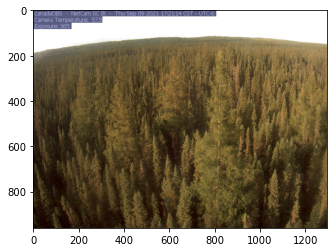

In [9]:
model_path = 'canadaOBS_lightning_logs/version_0/checkpoints/epoch=49-step=299.ckpt'
categories = ['too dark', 'snow', 'no snow'] # The order of categories should match the training order!
n_classes = len(categories)
model = load_model_from_file(model_path, n_classes)

site_name = 'canadaOBS'
url = 'https://phenocam.sr.unh.edu/data/latest/canadaOBS.jpg'

run_model_online(model, site_name, categories, url)

Offline predictions for the canadaOBS site.

In [10]:
target_dir = 'canadaOBS_test'
run_model_offline(model, site_name, categories, target_dir) # Creates canadaojp_test/predictions.csv

# Your code here
To train a model, you can copy the example snippets from the above section and paste them in the below cell.